In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_regression

In [50]:
def make_data(
        n_samples=100, 
        n_features=1, 
        n_effective_groups=3, 
        n_visible_groups=None, 
        noise=0.1, 
        random_state=0,
        slope_min=-1,
        slope_max=1,
        slopes_shuffle="switch",
        intercept_min=-1,
        intercept_max=1,
        intercepts_shuffle="switch"):

    rng = np.random.RandomState(random_state)

    if n_visible_groups is None:
        n_visible_groups = n_effective_groups

    # distribute samples as evenly as possible across effective groups
    n_samples_per_group = np.array([n_samples // n_effective_groups] * n_effective_groups)
    n_samples_per_group[:n_samples % n_effective_groups] += 1

    # make intercepts
    intercepts = np.linspace(-1, 1, n_effective_groups)
    if intercepts_shuffle == "switch":
        intercepts = np.concatenate([intercepts[1::2], intercepts[::2]])
    print(intercepts)

    # make slopes
    slopes = np.zeros((n_effective_groups, n_features))
    for i in range(n_features):
        slopes[:,i] = np.linspace(slope_min, slope_max, n_effective_groups)
        if slopes_shuffle == "switch":
            slopes[:,i] = np.concatenate([slopes[1::2,i], slopes[::2,i]])
        print(slopes[:,i])
                
    # make data
    X_groups = []
    y_groups = []
    for i in range(n_effective_groups):
        X = rng.uniform(-1, 1, (n_samples_per_group[i], n_features))
        noise_values = rng.normal(0, noise, n_samples_per_group[i])
        y = X.dot(slopes[i,:]) + intercepts[i] + noise_values
        X_groups.append(X)
        y_groups.append(y)

    X = np.concatenate(X_groups)
    y = np.concatenate(y_groups)
    effective_groups = np.repeat(np.arange(n_effective_groups), n_samples_per_group)

    # shuffle
    shuffle_idx = rng.permutation(np.arange(n_samples))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    effective_groups = effective_groups[shuffle_idx]

    return X, y, effective_groups

In [97]:
X, y, effective_groups = make_data()

[ 0. -1.  1.]
[ 0. -1.  1.]


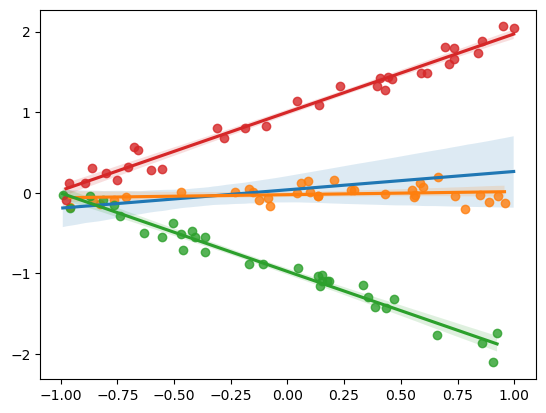

In [98]:
sns.regplot(x=X, y=y, label="fixed", scatter=False)
for g in np.unique(effective_groups):
    sns.regplot(x=X[effective_groups == g], y=y[effective_groups == g], scatter=True, label=g)
# plt.legend()

In [102]:
data = pd.DataFrame({"x0": X[:,0], "y": y, "g": effective_groups})

In [103]:
from statsmodels.regression.mixed_linear_model import MixedLM
model = MixedLM.from_formula("y ~ x0", data, groups=data["g"], re_formula="~1+x0")
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:              MixedLM Dependent Variable: y      
No. Observations:   100     Method:             REML   
No. Groups:         3       Scale:              0.0103 
Min. group size:    33      Log-Likelihood:     72.4643
Max. group size:    34      Converged:          Yes    
Mean group size:    33.3                               
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.003    0.570 0.005 0.996 -1.114  1.119
x0             0.009    0.561 0.016 0.987 -1.090  1.108
Group Var      0.973    9.678                          
Group x x0 Cov 0.958    9.522                          
x0 Var         0.942    9.375                          
=======================================================

"""

In [104]:
result.random_effects

{0: Group   -0.010901
 x0      -0.007562
 dtype: float64,
 1: Group   -0.980967
 x0      -0.966750
 dtype: float64,
 2: Group    0.991868
 x0       0.974312
 dtype: float64}

In [105]:
# y = []
# y_pred = []
# for g in np.unique(effective_groups):
#     X_group = X[effective_groups == g].flatten()
#     print(result.fe_params)
#     print(X_group)
#     pred_fe = model.predict(result.fe_params, exog=X_group)
#     pred_re = model.predict(result.random_effects[g], exog=X_group)
#     pred = pred_fe + pred_re
#     print(pred)
#     y.append(y[effective_groups == g])
#     y_pred.append(pred)
# y = np.concatenate(y)
# y_pred = np.concatenate(y_pred)

# sns.regplot(x=y, y=y_pred, label="fixed", scatter=False)

In [101]:
# # try something else
# from statsmodels.regression.mixed_linear_model import MixedLM
# model = MixedLM(y, X, groups=effective_groups, exog_re=X)
# result = model.fit()
# result.summary()